### Modelo de Riqueza
En este modelo se analiza una economía basada en agentes muy simple, extraída de la econofísica y que presenta un enfoque de mecánica estadística para la distribución de la riqueza [Dragulescu2002](https://arxiv.org/abs/cond-mat/0211175).
##### Reglas
Las reglas de nuestro modelo son:

- Hay algunos agentes.
- Todos los agentes comienzan con 1 unidad de dinero.
- En cada paso del modelo, un agente entrega 1 unidad de dinero (si la tiene) a otro agente.

A pesar de su simplicidad, este modelo produce resultados que a menudo son inesperados para quienes no están familiarizados con él. Para nuestros propósitos, también demuestra fácilmente las funciones principales de Mesa.
##### Imports
Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:

- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de mesa es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [10]:
# IMPORTS
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
# CLASSES
class MoneyAgent(Agent):
    def __init__ (self, id, model):
        super().__init__(id, model)
        self.wealth = 1

    def move(self):
        possible_cells = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_cells)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1
        
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N-i) for i, xi in enumerate(x)) / (N * sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    def __init__ (self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

        for i in range(self.num_agents):
            agent = MoneyAgent(i, self)
            self.schedule.add(agent)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [12]:
NUM_AGENTS = 50
WIDTH = 10
HEIGHT = 10
STEPS = 5

model = MoneyModel(NUM_AGENTS, WIDTH, HEIGHT)
for i in range(STEPS):
    model.step()

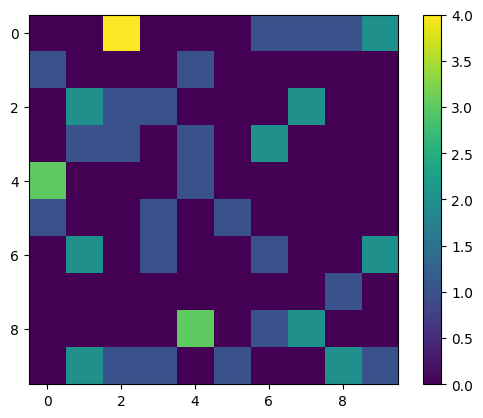

In [13]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    (cell_content, (x, y)) = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

(array([1875., 1747.,  991.,  297.,   73.,   15.,    2.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

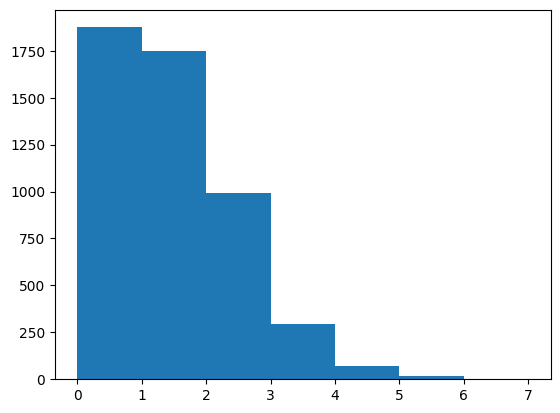

In [14]:
all_wealth = []
for i in range(100):
    model = MoneyModel(NUM_AGENTS, WIDTH, HEIGHT)
    for j in range(STEPS):
        model.step()
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)
plt.hist(all_wealth, bins=range(max(all_wealth) + 1))

In [15]:
# params = {"with": 10, "height": 10, "num_agents": range(10, 500, 10)}
# batch_run(MoneyModel, params, iterations=5, max_steps=100, model_reporters={"Gini": compute_gini})